Here I am just reproducing work from the mobely lab on making MSMs from our T4 Lysozyme data https://github.com/sgill2/LabStuff/blob/master/emma_template.py

In [1]:
#from pyemma import KmeansClustering as Kmeans
#import pyemma.pyemma
import pyemma


In [2]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt

In [3]:
import pickle
import numpy as np

import os
import matplotlib

import matplotlib.pyplot as plt

import glob
import fnmatch
import random
import time

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [4]:
import mdtraj as md

In [5]:
pyemma.__version__

u'2.1.1+98.g9d0898c'

In [6]:
###Functions
def plot_sampled_function(xall, yall, zall, ax=None, nbins=100, nlevels=20, cmap=matplotlib.cm.bwr, cbar=True, cbar_label=None):
    # histogram data
    xmin = np.min(xall)
    xmax = np.max(xall)
    dx = (xmax - xmin) / float(nbins)
    ymin = np.min(yall)
    ymax = np.max(yall)
    dy = (ymax - ymin) / float(nbins)
    # bin data
#    eps = x
    xbins = np.linspace(xmin - 0.5*dx, xmax + 0.5*dx, num=nbins)
    ybins = np.linspace(ymin - 0.5*dy, ymax + 0.5*dy, num=nbins)
    xI = np.digitize(xall, xbins)
    yI = np.digitize(yall, ybins)
    # result
    z = np.zeros((nbins, nbins))
    N = np.zeros((nbins, nbins))
    # average over bins
    for t in range(len(xall)):
        z[xI[t], yI[t]] += zall[t]
        N[xI[t], yI[t]] += 1.0
    z /= N
    # do a contour plot
    extent = [xmin, xmax, ymin, ymax]
    if ax is None:
        ax = gca()
    ax.contourf(z.T, 100, extent=extent, cmap=cmap)
    if cbar:
        cbar = plt.colorbar()
        if cbar_label is not None:
            cbar.ax.set_ylabel(cbar_label)

    return ax

In [7]:
def plot_sampled_density(xall, yall, zall, ax=None, nbins=100, cmap=matplotlib.cm.Blues, cbar=True, cbar_label=None):
    return plot_sampled_function(xall, yall, zall, ax=ax, nbins=nbins, cmap=cmap, cbar=cbar, cbar_label=cbar_label)


In [8]:
def plot_labels(ax=None):
    if ax is None:
        ax = gca()
    ax.text(-2, -4.7, '1', fontsize=20, color='black')
    ax.text(-1.2, -5, '2', fontsize=20, color='black')
    ax.text(-4.2, 1.5, '3', fontsize=20, color='black')
    ax.text(-0.1, 0, '4', fontsize=20, color='white')

In [9]:
def make_keys(msm_list, globlist, numclusters):

    for index, entry in enumerate(msm_list):
        print entry
        name = os.path.splitext(globlist[index])[0]
        keys = {}
        for i in range(numclusters):
            keys[i] = []
        for number, cluster in enumerate(entry):
            keys[cluster].append(number)
        pickle_name = 'keys_' + name + '.pickle'
        with open(pickle_name, 'w') as f:
            pickle.dump(keys, f)
    return True

In [10]:
def update_progress(progress, total):
    print '\r[{0}] {1}%'.format('#'*(progress/total), progress)

In [11]:
def plot_edit(xall, yall, weights=None, ax=None, nbins=100, offset=0.0001,
                     cmap='spectral', cbar=True, cbar_label='Free energy (kT)'):
    """Free energy plot given 2D scattered data
    Builds a 2D-histogram of the given data points and plots -log(p) where p is
    the probability computed from the histogram count.
    Parameters
    ----------
    xall : ndarray(T)
        sample x-coordinates
    yall : ndarray(T)
        sample y-coordinates
    weights : ndarray(T), default = None
        sample weights. By default all samples have the same weight
    ax : matplotlib Axes object, default = None
        the axes to plot to. When set to None the default Axes object will be used.
    nbins : int, default=100
        number of histogram bins used in each dimension
    offset : float, default=0.1
        small additive shift to the histogram. This creates a small bias to the
        distribution, but gives a better visual impression with the default
        colormap.
    cmap : matplotlib colormap, optional, default = None
        the color map to use. None will use pylab.cm.spectral.
    cbar : boolean, default=True
        plot a color bar
    cbar_label : str or None, default='Free energy (kT)'
        colorbar label string. Use None to suppress it.
    Returns
    -------
    ax : Axes object containing the plot
    fig : Figure object containing the plot
    """
    import matplotlib.pylab as _plt
    z, x, y = np.histogram2d(xall, yall, bins=nbins, weights=weights)
    z += offset
#    print 'x edges'; print x
#    print 'y edges'; print y
    # compute free energies
    F = -np.log(z)
    # do a contour plot
    #extent = [x[0], x[-1], y[0], y[-1]]
    #if ax is None:
    #    ax = pp.gca()
    #CS = ax.contourf(F.T, 100, extent=extent, cmap=cmap)
    #if cbar:
    #    cbar = pp.colorbar(CS)
    #    if cbar_label is not None:
    #        cbar.ax.set_ylabel(cbar_label)

    return F, x, y

In [12]:
def get_frame_membership(temp_mapped_data):
    frametoindex = {} 
    frame_counter = 0
    total_length = 0

    for index, entry in enumerate(temp_mapped_data):
    #index is used to to map to the traj_list index
    #entry is the individual trajectory (that you will iterate through)
    #keeping track of total length of the trajectory using the next two lines
        total_length = total_length + len(entry)
    #frame_membership is used to
        frame_membership = range(frame_counter, (frame_counter + len(entry)))

        for frame_in_traj, entry2 in enumerate(frame_membership):
            frametoindex[entry2] = [index, frame_in_traj]
        frame_counter = frame_counter + len(entry)
#    print 'new frame to index'
#    print frametoindex
    return frametoindex
    

In [13]:
def flatten_data(mapped_data, dim):
    assert type(dim) == int
    temp_mapped_data = np.copy(mapped_data)
    frame_counter = 0
    total_length = 0
    for index, entry in enumerate(temp_mapped_data):
    #index is used to to map to the traj_list index
    #entry is the individual trajectory (that you will iterate through)
    #keeping track of total length of the trajectory using the next two lines
        total_length = total_length + len(entry)
    #frame_membership is used to
    print 'frame total is ', total_length
    debug_mapped_data = np.zeros((total_length, dim))
    counter = 0
    #flatten mapped_data (which is the traj clusters)
    for array in np.copy(mapped_data):
#        print 'array', array
        len_traj = np.shape(array)[0]
        print len_traj
        print np.shape(debug_mapped_data)
        for entry in range(len_traj):
#            print 'debug_mapped counter'
#            print debug_mapped_data[counter]
#            print 'array[entry]'
#            print array[entry]
            debug_mapped_data[counter] = array[entry]
            counter = counter + 1
    print debug_mapped_data
    return debug_mapped_data

In [14]:
#def grep_folder(traj_list, folder, globname):
#    path = folder
#    traj_append = [os.path.join(dirpath, f)
#        for dirpath, dirnames, files in os.walk(path)
#        for f in fnmatch.filter(files, globname)]
#    print traj_append
#    for entry in traj_append:
#        traj_list.append(entry)
#    return traj_list

Those were the functions, here is the magic!

In [15]:
# load trajectories
path_to_trajs = '/cbio/jclab/projects/fah/fah-data/munged-with-time/no-solvent/10466/*0-clone0.h5'
from glob import glob
filenames = glob(path_to_trajs)#[:50] # here looking at only the first 50
trajs = [md.load(f) for f in filenames]

In [16]:
sum([len(traj) for traj in trajs])


21639

In [17]:
trajs[0].timestep

250.0

In [18]:
top_file = '/cbio/jclab/projects/fah/fah-data/munged/no-solvent/10470/run0-clone0.h5'
feat = coor.featurizer(top_file)
prot_index = np.array(feat.select("(resid >= 105) and (resid <= 115) and (name == CA)"))
#prot_index = np.array([])
added_residues = np.array(feat.select("(resid >= 100) and (resid <= 102) and (name == CA)"))

In [19]:
prot_lig = np.concatenate((prot_index, added_residues), axis=0)


In [20]:
feat.add_backbone_torsions(selstr="(resid >= 105) and (resid <= 115)")


In [21]:
feat.add_distances(prot_lig)

print 'feat dimension'
print feat.dimension()

inp = coor.source(filenames, feat)
##Variables
lagtime = 50
tica_lagtime = 400

#number of PCCA clusters
n_sets = 3

print 'feat dimension'
print feat.dimension()

04-05-16 15:02:43 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  The 1D arrays input for add_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features
feat dimension
113
feat dimension
113


In [22]:

dataset = []
nlist = []

if 1:
    n_clusters = 200
    tica_obj = coor.tica( dim=2, lag=tica_lagtime, kinetic_map=True)

    input_data = coor.cluster_kmeans( k=n_clusters, max_iter=50)

    disc = coor.discretizer(inp, tica_obj, input_data, stride=1, chunksize=10)
    disc.parametrize()
print tica_obj.cumvar
#TICA output is Y
Y = tica_obj.get_output()
print np.shape(Y)
#print 'Y[0]'
#print Y[0]
print 'number of trajetories = ', np.shape(Y)[0]
#

04-05-16 15:05:33 pyemma.coordinates.clustering.kmeans.KmeansClustering[5] INFO     Cluster centers converged after 10 steps.
[ 0.0625822   0.11530445  0.16042961  0.20545525  0.24191226  0.27548391
  0.30828022  0.34045792  0.37117383  0.39877085  0.42590001  0.45242494
  0.47832028  0.50318681  0.52750555  0.5510084   0.57275986  0.59393851
  0.61495399  0.63392731  0.65271911  0.66980569  0.68591688  0.7016339
  0.71718272  0.73191145  0.74628678  0.75978723  0.77270758  0.78554589
  0.79805277  0.81001678  0.8215063   0.83195043  0.84203764  0.85206423
  0.86133681  0.86999089  0.87815736  0.88577484  0.89315332  0.90027447
  0.90703165  0.91358807  0.91976642  0.92556682  0.93106284  0.9364184
  0.94154751  0.94645409  0.95116651  0.95570519  0.9601235   0.964434
  0.96798151  0.97107704  0.97412439  0.97689819  0.97948384  0.98195918
  0.98395449  0.98587097  0.98773794  0.989574    0.99132378  0.99270056
  0.99385281  0.9949438   0.99589958  0.99671871  0.99750365  0.9980524
  0

In [23]:
#mapped_data is the TICA clustered data mapped to the microstates (so integer valued)
mapped_data =input_data.dtrajs

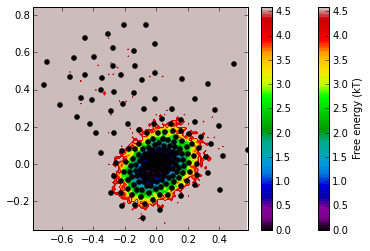

In [30]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1])
cc_x = input_data.clustercenters[:,0]
cc_y = input_data.clustercenters[:,1]
plt.plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='black')
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cbar_label=None);
plt.savefig('msm_tica_clusters.png')


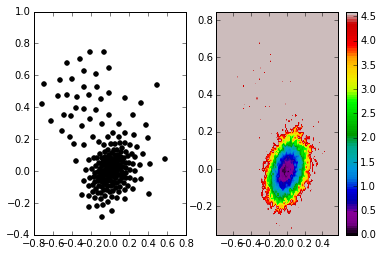

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.scatter(cc_x, cc_y, marker='o', color='black') 
ax2 = mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cbar_label=None)
plt.savefig('msm_tica_all.png')


In [32]:
#actually generate MSM from data
msm_from_data = msm.estimate_markov_model(dtrajs=mapped_data, lag=lagtime)

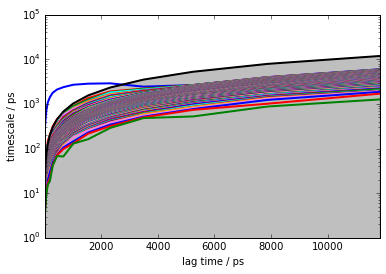

In [34]:
#plot and/or save implied timescales, if specified
its = msm.timescales_msm(dtrajs=mapped_data, lags=500)
mplt.plot_implied_timescales(its, show_mean=False, ylog=True, dt=25, units='ps', linewidth=2)
plt.savefig('msm_its.png')



(<matplotlib.figure.Figure at 0x7f724f03fe10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f726fe2b690>)

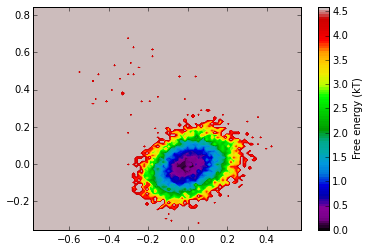

In [35]:

####
#pcca cluster using specified n_sets
msm_from_data.pcca(n_sets)
pcca_return = msm_from_data.pcca(n_sets)
pcca_return.metastable_sets
pcca_return.metastable_assignment
pcca_return.transition_matrix
pcca_dist = msm_from_data.metastable_distributions
membership = msm_from_data.metastable_memberships
pcca_sets = msm_from_data.metastable_sets
color_list = ['cyan', 'blue', 'green', 'black', 'orange', 'purple', 'pink', 'red']
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1])

200
[-0.34348276 -0.50567162 -0.52438539 -0.71236247 -0.26727983 -0.13866439
 -0.3820585 ] [ 0.46446088  0.2531485   0.57029021  0.42267895  0.38913634  0.5280695
  0.1666442 ]
[-0.09106135 -0.55088657 -0.2729381  -0.45570061 -0.22274083 -0.06458575
 -0.40843689 -0.45644811 -0.14298278 -0.39649832 -0.28878745 -0.3535949
 -0.69262701 -0.47788909 -0.27603045 -0.61575764 -0.20657441 -0.3098945 ] [ 0.45258749  0.46803468  0.62652886  0.67887872  0.47836575  0.74812466
  0.34235623  0.47729284  0.60709208  0.57803369  0.2835156   0.39543569
  0.54751247  0.35452765  0.52937889  0.31555107  0.7463724   0.69982702]
[-0.03438711  0.19257924 -0.04303582  0.07938557 -0.20798656  0.08329126
  0.10444031 -0.12551264 -0.05530393  0.01652856  0.17329878  0.0234349
 -0.1578217  -0.04645139  0.01611338  0.28292879 -0.12885854  0.03015669
  0.15798813 -0.1471547  -0.05094998 -0.08958516  0.32751888 -0.20910516
  0.00864085 -0.03204952  0.2595115   0.13411032  0.07922296 -0.08299094
  0.06300085 -0.0245

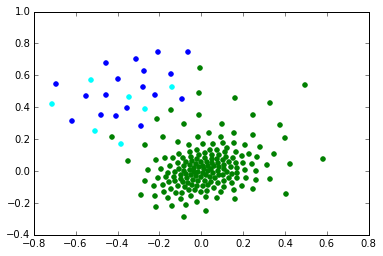

In [36]:

print len(msm_from_data.metastable_assignments)
for number in range(n_sets):
    print input_data.clustercenters[pcca_sets[number],0], input_data.clustercenters[pcca_sets[number],1]
for number in range(n_sets):
    plt.scatter(input_data.clustercenters[pcca_sets[number],0], input_data.clustercenters[pcca_sets[number],1], color=color_list[number])

plt.savefig('msm_pcca.png')


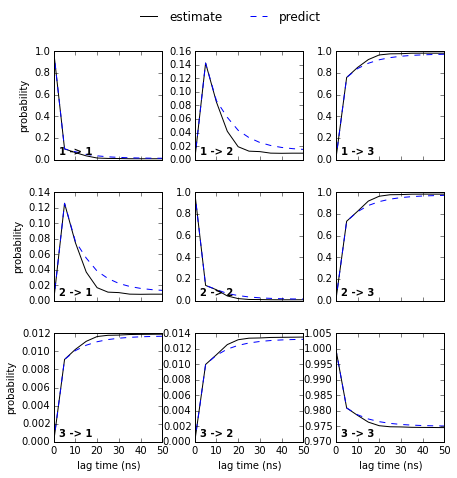

In [38]:
#####CK TEST, if specified

ck = msm_from_data.cktest(n_sets, mlags=11)

mplt.plot_cktest(ck, diag=False, figsize=(7,7), layout=(n_sets,n_sets), padding_top=0.1, y01=False, padding_between=0.3, dt=0.1, units='ns')

plt.savefig('msm_ck.png')


04-05-16 15:19:07 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[8] WARNING  Requested coarse-grained model with 3 metastable states at lag=50.The ratio of relaxation timescales between 3 and 4 states is only 1.01772426509 while we recommend at least 1.5.  It is possible that the resulting HMM is inaccurate. Handle with caution.
hmm
[ 0.01083456  0.01345074  0.97571469]
[[  1.85269927e-04   8.27638611e-01   1.72176119e-01]
 [  6.66662110e-01   3.10941951e-02   3.02243695e-01]
 [  1.91188350e-03   4.16658966e-03   9.93921527e-01]]


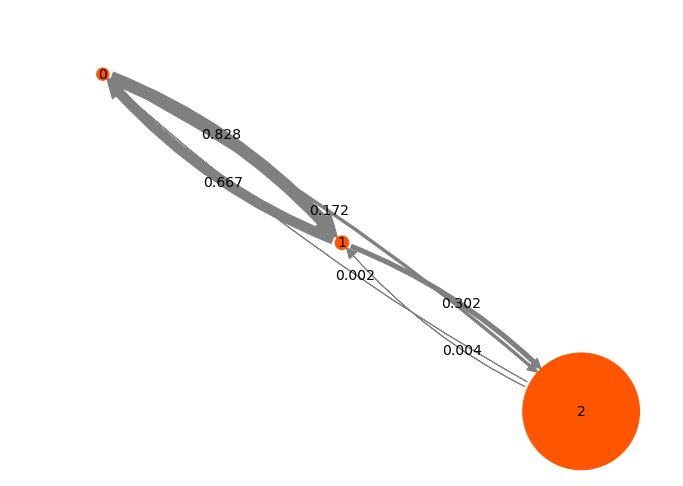

In [42]:

#####
#make hmm from msm and pcca clusters
hmm = msm_from_data.coarse_grain(n_sets)
print 'hmm'
print hmm.stationary_distribution
print hmm.transition_matrix
np.savetxt('msm_populations.txt', hmm.stationary_distribution)
np.savetxt('msm_transmat.txt', hmm.transition_matrix)
#plot msm using pyemma function
mplt.plot_markov_model(hmm, minflux=4e-4, arrow_label_format='%.3f')

plt.savefig('msm_hmm_markovmodel.png')


[2 2 2 0 2 2 0 2 1 2 2 2 2 2 1 2 2 2 2 0 2 2 2 2 0 0 2 0 1 0 2 2 2 0 2 1 2
 2 0 1 1 1 2 2 2 2 0 2 2 0 2 2 1 2 2 1 2 0 0 2 2 1 2 2 0 2 0 2 0 2 2 2 2 2
 0 1 2 2 0 2 0 2 1 1 2 1 2 1 2 2 0 2 0 2 2 2 0 2 0 2 2 2 0 0 0 2 2 2 1 2 2
 2 2 0 2 1 0 2 2 2 1 2 1 2 2 2 2 2 1 0 2 2 1 2 0 1 2 2 2 2 2 1 1 1 0 0 0 1
 0 2 2 2 2 2 2 0 2 2 1 0 2 0 2 2 2 2 2 2 0 1 0 2 1 2 2 1 1 2 2 1 2 2 0 1 2
 1 1 2 2 2 1 0 1 2 2 1 0 1 1 0]
[array([  3,  19,  66,  80, 116, 129, 145]), array([ 14,  24,  28,  49,  58,  61,  75,  98, 108, 128, 132, 143, 147,
       169, 176, 192, 197, 198]), array([  0,   1,   2,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        15,  16,  17,  18,  20,  21,  22,  23,  25,  26,  27,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  50,  51,  52,  53,  54,  55,  56,  57,
        59,  60,  62,  63,  64,  65,  67,  68,  69,  70,  71,  72,  73,
        74,  76,  77,  78,  79,  81,  82,  83,  84,  85,  86,  87,  88,
        89

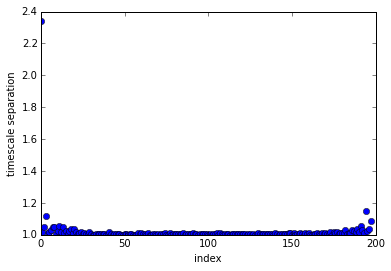

In [44]:

#plot hmm timescales
print hmm.metastable_assignments
plt.plot(msm_from_data.timescales()[:-1]/msm_from_data.timescales()[1:], linewidth=0,marker='o')
plt.xlabel('index'); plt.ylabel('timescale separation');

plt.savefig('msm_hmm_timescales.png')


pcca_sets_6 = msm_from_data.metastable_sets
print pcca_sets_6
pcca_dist = msm_from_data.metastable_distributions

In [46]:
#if args.output specified, saves random frames from each pcca cluster

outfiles = []
for number in range(n_sets):
    pcca_name = './pcca_'+str(number)+'_samples.xtc'
    outfiles.append(pcca_name)
    #outfiles = outfiles[0:n_sets]
pcca_samples = msm_from_data.sample_by_distributions(pcca_dist, 100)
#coor.save_trajs(inp, pcca_samples, outfiles=['./pcca1_10samples.xtc','./pcca2_10samples.xtc',])
coor.save_trajs(inp, pcca_samples, outfiles=outfiles)

04-05-16 15:21:34 pyemma.coordinates.api INFO     Created file ./pcca_0_samples.xtc
04-05-16 15:21:39 pyemma.coordinates.api INFO     Created file ./pcca_1_samples.xtc
04-05-16 15:21:44 pyemma.coordinates.api INFO     Created file ./pcca_2_samples.xtc


['./pcca_0_samples.xtc', './pcca_1_samples.xtc', './pcca_2_samples.xtc']